# Tutorial 03

## partial-sky ABS pipeline (without noise)

To validate the ABS method we have simulated a few foregrounds maps including dust and synchrotron at 30, 95, 150 and 353 GHz, using PySM package. CAMB is utilized to predict the CMB power spectra with respect to the Planck best fit 2018 results, from which random realizations of CMB anisotropies are obtained. For the tensor-to-scalar ratio, we set it as 0.05 for the generation of CMB maps. White noise maps are generated according to the Planck level.

In [1]:
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import afra as af
from afra.tools.ps_estimator import pstimator
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

NSIDE = 128
fwhm = [0.5*np.pi/180.,0.3*np.pi/180.,0.2*np.pi/180.,0.08*np.pi/180.]  # FWHM for beam effect

map30f = hp.read_map('./data/pysm_s1d1_30.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map95f = hp.read_map('./data/pysm_s1d1_95.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map150f = hp.read_map('./data/pysm_s1d1_150.fits',field=[0,1,2],dtype=np.float32,verbose=0)
map353f = hp.read_map('./data/pysm_s1d1_353.fits',field=[0,1,2],dtype=np.float32,verbose=0)
cmb_cl = hp.read_cl('./data/camb_cls.fits')

ell = np.arange(cmb_cl.shape[1])
mapcmb = hp.synfast(cmb_cl,nside=NSIDE,new=True,verbose=0)
map30 = hp.smoothing(map30f+mapcmb,fwhm=fwhm[0],verbose=0)
map95 = hp.smoothing(map95f+mapcmb,fwhm=fwhm[1],verbose=0)
map150 = hp.smoothing(map150f+mapcmb,fwhm=fwhm[2],verbose=0)
map353 = hp.smoothing(map353f+mapcmb,fwhm=fwhm[3],verbose=0)

mask = hp.read_map('./data/ali_mask.fits',dtype=bool,verbose=0)

APOSCALE = 6.
BINNING = 20
LMIN = 50
LMAX = 200
est = pstimator(nside=NSIDE,mask=mask.reshape(1,-1),aposcale=APOSCALE,psbin=BINNING,lmin=LMIN,lmax=LMAX)
cmb_dl = est.auto_teb(mapcmb)
cmb_dl = np.vstack([cmb_dl[0],cmb_dl[1],cmb_dl[4],cmb_dl[6]])

# calculate binned CMB band-power from input Cl
#cmb_dl = np.zeros((4,len(est.modes)))
#cmb_dl[0] = est.modes
#for i in range(len(est.modes)):
#    lrange = np.array(est._b.get_ell_list(i))
#    factor = 0.5*lrange*(lrange+1)/np.pi
#    w = np.array(est._b.get_weight_list(i))
#    for j in range(3):
#        cmb_dl[j+1,i] = np.sum(w*cmb_cl[j,lrange]*factor)

- PS estimation requires a built-in PS estimator (by default NaMaster)
- use `abspipe`

ABS T mode relative error dist: mean=-0.034424, std=0.063886
ABS E mode relative error dist: mean=-0.011880, std=0.010450
ABS B mode relative error dist: mean=-0.011451, std=0.007830


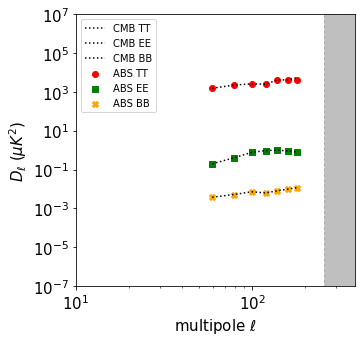

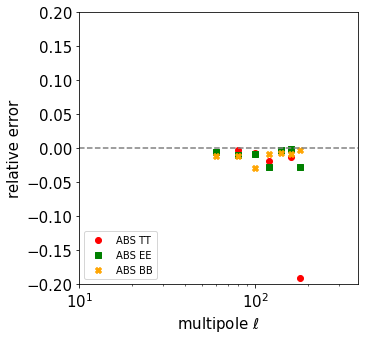

In [2]:
# T maps
fullmap = dict()
fullmap[30] = map30[0].reshape(1,-1)
fullmap[95] = map95[0].reshape(1,-1)
fullmap[150] = map150[0].reshape(1,-1)
fullmap[353] = map353[0].reshape(1,-1)
pipeline = af.abspipe(fullmap,mask=mask.reshape(1,-1),fwhms=fwhm)
rslt_t = pipeline(aposcale=APOSCALE,psbin=BINNING,lmin=LMIN,lmax=LMAX,shift=None,threshold=None,verbose=True)

# Q,U maps
fullmap.clear()
fullmap[30] = map30[1:]
fullmap[95] = map95[1:]
fullmap[150] = map150[1:]
fullmap[353] = map353[1:]
pipeline = af.abspipe(fullmap,mask=mask.reshape(1,-1),fwhms=fwhm)
rslt_eb = pipeline(aposcale=APOSCALE,psbin=BINNING,lmin=LMIN,lmax=LMAX,shift=None,threshold=None,verbose=True)

fig,ax = plt.subplots(figsize=(5,5))

ax.scatter(rslt_t[0],rslt_t[1],
           color='red',marker='o',label=r'ABS TT')
ax.scatter(rslt_eb[0],rslt_eb[1],
           color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],rslt_eb[2],
           color='orange',marker='X',label=r'ABS BB')

ax.plot(cmb_dl[0],cmb_dl[1],color='black',linestyle=':',label=r'CMB TT')
ax.plot(cmb_dl[0],cmb_dl[2],color='black',linestyle=':',label=r'CMB EE')
ax.plot(cmb_dl[0],cmb_dl[3],color='black',linestyle=':',label=r'CMB BB')

ax.fill_between((2*NSIDE,3*NSIDE),(1e-7,1e-7),(1e7,1e7),
                color='gray',linestyle='--',alpha=0.5)

ax.set_yscale('log')
ax.set_xscale('log')
ax.legend(loc=2)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'$D_\ell$ ($\mu K^2$)',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((1.e-7,1.e7))
ax.set_xlim((10,3*NSIDE))

fig,ax = plt.subplots(figsize=(5,5))

tt_rel = (rslt_t[1]-cmb_dl[1])/cmb_dl[1]
ee_rel = (rslt_eb[1]-cmb_dl[2])/cmb_dl[2]
bb_rel = (rslt_eb[2]-cmb_dl[3])/cmb_dl[3]

ax.scatter(rslt_t[0],tt_rel,
            color='red',marker='o',label=r'ABS TT')
ax.scatter(rslt_eb[0],ee_rel,
            color='green',marker='s',label=r'ABS EE')
ax.scatter(rslt_eb[0],bb_rel,
            color='orange',marker='X',label=r'ABS BB')
ax.plot((10,3*NSIDE),(0,0),color='grey',linestyle='--')

ax.set_xscale('log')
ax.legend(loc=3)
ax.set_xlabel(r'multipole $\ell$',fontsize=15)
ax.set_ylabel(r'relative error',fontsize=15)
ax.tick_params(axis='both', labelsize=15)
ax.set_ylim((-0.2,0.2))
ax.set_xlim((10,3*NSIDE))

print ('ABS T mode relative error dist: mean=%f, std=%f' % (np.mean(tt_rel), np.std(tt_rel)))
print ('ABS E mode relative error dist: mean=%f, std=%f' % (np.mean(ee_rel), np.std(ee_rel)))
print ('ABS B mode relative error dist: mean=%f, std=%f' % (np.mean(bb_rel), np.std(bb_rel)))

end